In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

%matplotlib inline

In [2]:

# We will have a look at the data explanation and data we have got for fraud detection analysis

# Note - We can dump the data into SQL tables and analyze, but for ease of presentation and visualization,
# let's use python pandas dataframes which can support all operations same as of SQL (joins e.t.c)


# ********** DATA EXPLANATION ***************

1. countries.csv
	- a table with all alpha-numeric representations of countries. You may need to use this to standardise country codes to one format
2. fx_rates.csv
	- a table with fx rates on a particular day
3. fraudsters.csv
	- this is list of IDs of users who have been identified as fraudsters but there's a bunch we haven't found yet!
4. train_transactions.csv
	- all transactions conducted by users
	- **amount** is denominated in integers at the lowest unit. e.g. 5000 GBP => 50 GBP (because the lowest unit in GBP is a penny, w/ 100 pence = 1 GBP)
	- **entry_method** is only relevant for card transactions (CARD_PAYMENT, ATM); you may ignore it for other transactions. The values are:
		misc - unknown,
		chip - chip on card,
		mags - magstripe on card,
		manu - manual entry of card details,
		cont - contactless/tap, 
		mcon - special case of magstripe & contactless,
	- **source** is associated with an external party we use for handling this type of transaction. (e.g. all {CARD_PAYMENT, ATM} use GAIA)
5. train_users.csv
	- a table of user data
	- **kyc** column indicates the status of the user's identity verification process
	- **terms_version** column indicates the user's current version of the Revolut app
6. currency_details.csv
	- a table with iso codes and exponents for currencies
	- **exponent** column can be used to convert the integer amounts in the transactions table into cash amounts. (e.g for 5000 GBP, exponent = 2, so we apply: 5000/(10^2) = 50 GBP)

********** END OF DATA EXPLANATION ***************


In [3]:
# Let us create data frames for each of the tables we have got

In [4]:
df_fraudsters = pd.read_csv("hc_data/fraudsters.csv")
df_countries = pd.read_csv("hc_data/countries.csv")
df_currency_details = pd.read_csv("hc_data/currency_details.csv")
df_fx_rates = pd.read_csv("hc_data/fx_rates.csv")
df_transactions = pd.read_csv("hc_data/transactions.csv")
df_users = pd.read_csv("hc_data/users.csv")

In [5]:
# Now, let's us have a look at the first few rows of each table to get some idea about the data

In [6]:
df_fraudsters.head()

,Unnamed: 0,user_id
0,0,5270b0f4-2e4a-4ec9-8648-2135312ac1c4
1,1,848fc1b1-096c-40f7-b04a-1399c469e421
2,2,27c76eda-e159-4df3-845a-e13f4e28a8b5
3,3,a27088ef-9452-403d-9bbb-f7b10180cdda
4,4,fb23710b-609a-49bf-8a9a-be49c59ce6de


In [7]:
df_fraudsters.shape # 300 fraud users data available

(300, 2)

In [8]:
df_countries.head()

,code,name,code3,numcode,phonecode
0,AF,Afghanistan,AFG,4.0,93
1,AL,Albania,ALB,8.0,355
2,DZ,Algeria,DZA,12.0,213
3,AS,American Samoa,ASM,16.0,1684
4,AO,Angola,AGO,24.0,244


In [9]:
df_currency_details.head()

,currency,iso_code,exponent,is_crypto
0,AED,784.0,2.0,False
1,AFN,971.0,2.0,False
2,ALL,8.0,2.0,False
3,AMD,51.0,2.0,False
4,ANG,532.0,2.0,False


In [73]:
df_fx_rates.head()
df_fx_rates[df_fx_rates['ccy']=='INR']

,base_ccy,ccy,rate
12,EUR,INR,0.019274
40,GBP,INR,0.017928
69,USD,INR,0.021399


In [11]:
df_transactions.head()

,Unnamed: 0,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
0,0,GBP,3738,COMPLETED,2015-10-11 09:05:43.016000,bar,AUS,misc,7285c1ec-31d0-4022-b311-0ad9227ef7f4,CARD_PAYMENT,GAIA,5a9ee109-e9b3-4598-8dd7-587591e6a470
1,1,GBP,588,COMPLETED,2015-10-11 20:08:39.150000,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,28d68bf4-460b-4c8e-9b95-bcda9ab596b5
2,2,GBP,1264,COMPLETED,2015-10-11 11:37:40.908000,NaN,UKR,misc,0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0,CARD_PAYMENT,GAIA,1f1e8817-d40b-4c09-b718-cfc4a6f211df
3,3,GBP,66,REVERTED,2015-10-11 20:08:35.310000,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,a7aaf78c-d201-456f-9e6d-612a795e8c32
4,4,GBP,968,COMPLETED,2015-10-11 02:46:47.640000,supermarket,NZL,misc,821014c5-af06-40ff-91f4-77fe7667809f,CARD_PAYMENT,GAIA,27dd99a2-5539-4ba9-876a-1a94abc2701f


In [12]:
df_transactions.shape

(688651, 12)

In [13]:
df_users.head()

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
0,0,0,PASSED,1971,GB,ACTIVE,2017-08-06 07:33:33.341000,2018-05-25,GB||JE||IM||GG,1,1872820f-e3ac-4c02-bdc7-727897b60043
1,1,0,PASSED,1982,GB,ACTIVE,2017-03-07 10:18:59.427000,2018-01-01,GB||JE||IM||GG,1,545ff94d-66f8-4bea-b398-84425fb2301e
2,2,0,PASSED,1973,ES,ACTIVE,2018-05-31 04:41:24.672000,2018-09-20,ES,1,10376f1a-a28a-4885-8daa-c8ca496026bb
3,3,0,PASSED,1986,FR,ACTIVE,2018-06-01 17:24:23.852000,2018-05-25,FR,1,fd308db7-0753-4377-879f-6ecf2af14e4f
4,4,0,PASSED,1989,GB,ACTIVE,2017-08-09 15:03:33.945000,2018-09-20,GB||JE||IM||GG,1,755fe256-a34d-4853-b7ca-d9bb991a86d3


In [14]:
df_users.shape # total 10300 users data available

(10300, 11)

In [15]:
# Now let us have a look at the fraud users data by joining it with user and transaction tables 

In [16]:
## fraudsters joined with user table data 

In [17]:
df_fraud_users = pd.merge(df_users, df_fraudsters, how='inner', left_on='ID', right_on='user_id')

In [18]:
df_fraud_users.head()

,Unnamed: 0_x,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID,Unnamed: 0_y,user_id
0,8451,0,NONE,1988,GB,LOCKED,2017-09-19 01:55:22.376000,NaN,GB||JE||IM||GG,1,5270b0f4-2e4a-4ec9-8648-2135312ac1c4,0,5270b0f4-2e4a-4ec9-8648-2135312ac1c4
1,8452,0,PASSED,1994,GB,LOCKED,2018-06-16 15:55:43.800000,2018-05-25,PL,1,848fc1b1-096c-40f7-b04a-1399c469e421,1,848fc1b1-096c-40f7-b04a-1399c469e421
2,8453,0,PASSED,1997,GB,LOCKED,2018-05-11 18:20:45.608000,2018-05-25,GB||JE||IM||GG,1,27c76eda-e159-4df3-845a-e13f4e28a8b5,2,27c76eda-e159-4df3-845a-e13f4e28a8b5
3,8454,0,PASSED,1989,BE,LOCKED,2018-05-18 16:41:12.267000,2018-05-25,IN,1,a27088ef-9452-403d-9bbb-f7b10180cdda,3,a27088ef-9452-403d-9bbb-f7b10180cdda
4,8455,0,PASSED,1992,LT,LOCKED,2018-03-29 13:37:29.736000,2018-03-20,LT,1,fb23710b-609a-49bf-8a9a-be49c59ce6de,4,fb23710b-609a-49bf-8a9a-be49c59ce6de


In [19]:
df_fraud_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0_x             300 non-null    int64 
 1   FAILED_SIGN_IN_ATTEMPTS  300 non-null    int64 
 2   KYC                      300 non-null    object
 3   BIRTH_YEAR               300 non-null    int64 
 4   COUNTRY                  300 non-null    object
 5   STATE                    300 non-null    object
 6   CREATED_DATE             300 non-null    object
 7   TERMS_VERSION            232 non-null    object
 8   PHONE_COUNTRY            300 non-null    object
 9   HAS_EMAIL                300 non-null    int64 
 10  ID                       300 non-null    object
 11  Unnamed: 0_y             300 non-null    int64 
 12  user_id                  300 non-null    object
dtypes: int64(5), object(8)
memory usage: 32.8+ KB


In [20]:
# Lets plot some of the columns and see if the data has a pattern 
## fraud users plots

<AxesSubplot:title={'center':'TERMS_VERSION'}>

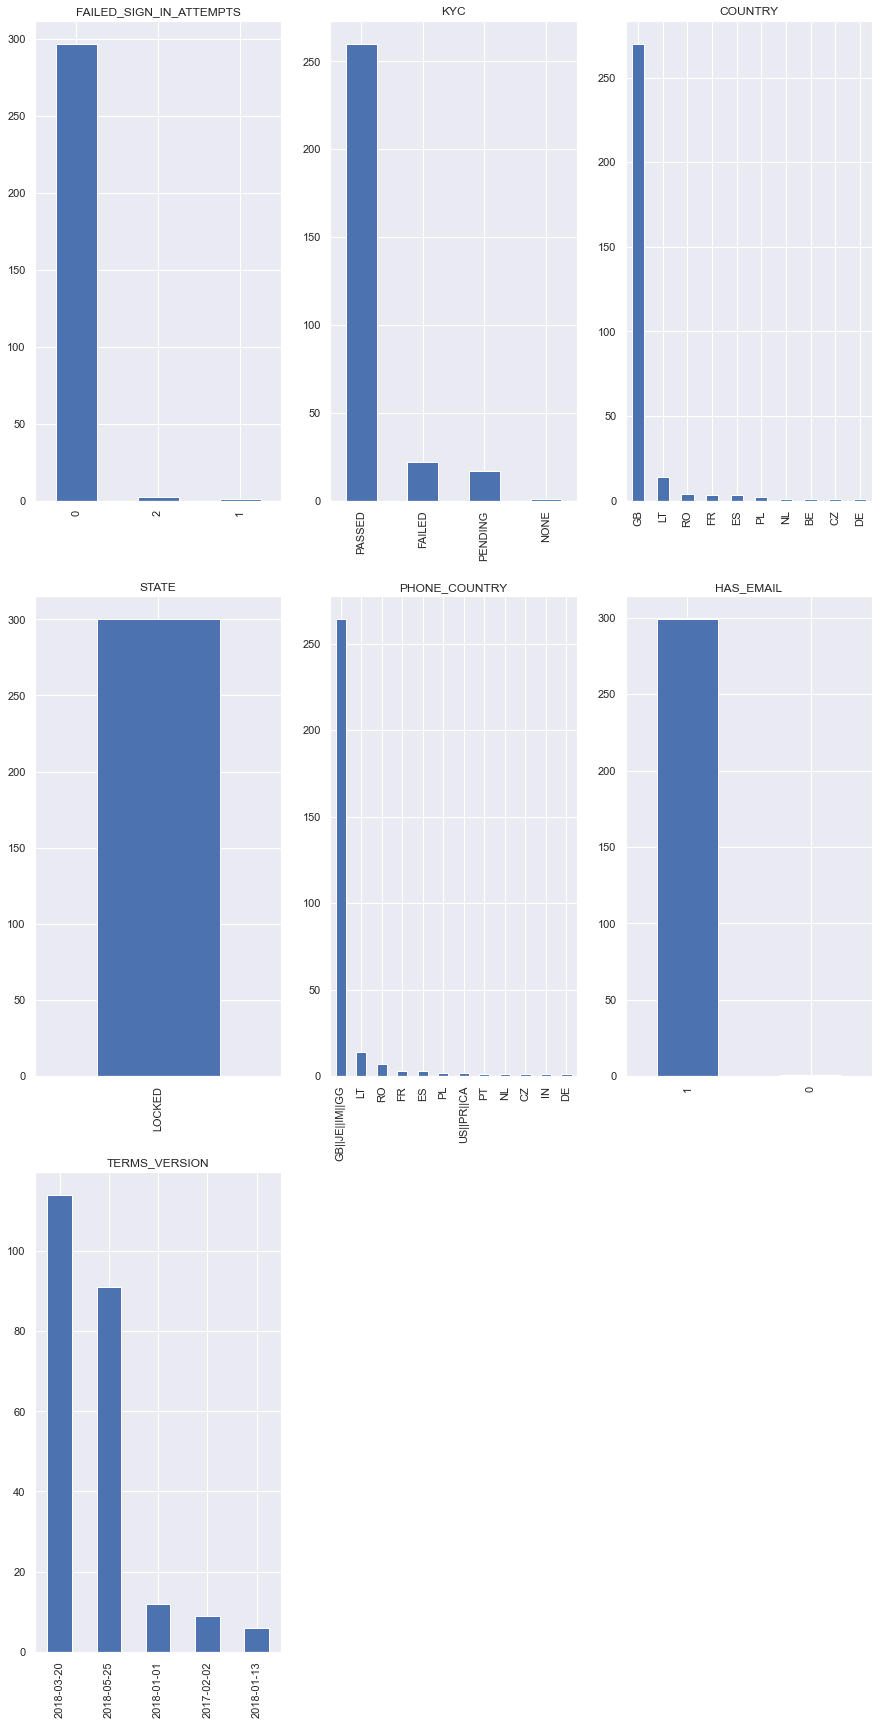

In [21]:
plt.subplot(331)
df_fraud_users['FAILED_SIGN_IN_ATTEMPTS'].value_counts(normalize=False).plot.bar(figsize=(15,30), title= 'FAILED_SIGN_IN_ATTEMPTS')

plt.subplot(332)
df_fraud_users['KYC'].value_counts(normalize=False).plot.bar(title= 'KYC')

plt.subplot(333)
df_fraud_users['COUNTRY'].value_counts(normalize=False).plot.bar(title= 'COUNTRY')

plt.subplot(334)
df_fraud_users['STATE'].value_counts(normalize=False).plot.bar(title= 'STATE')

plt.subplot(335)
df_fraud_users['PHONE_COUNTRY'].value_counts(normalize=False).plot.bar(title= 'PHONE_COUNTRY')

plt.subplot(336)
df_fraud_users['HAS_EMAIL'].value_counts(normalize=False).plot.bar(title= 'HAS_EMAIL')

plt.subplot(337)
df_fraud_users['TERMS_VERSION'].value_counts(normalize=False).plot.bar(title= 'TERMS_VERSION')



In [22]:
# Kyc data is mixed for fraud profiles, so can't say specifically that kyc can be param for fraud 

# We will go ahead and check mostly non fraud users data to see if we find difference in patterns 

In [23]:
## mostly non fraud users data plots 

In [24]:
df_nf_users = pd.merge(df_users, df_fraudsters, how='left', left_on='ID', right_on='user_id')

In [25]:
df_nf_users = df_nf_users[pd.isnull(df_nf_users["user_id"])]

In [26]:
df_nf_users.head()

,Unnamed: 0_x,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID,Unnamed: 0_y,user_id
0,0,0,PASSED,1971,GB,ACTIVE,2017-08-06 07:33:33.341000,2018-05-25,GB||JE||IM||GG,1,1872820f-e3ac-4c02-bdc7-727897b60043,NaN,NaN
1,1,0,PASSED,1982,GB,ACTIVE,2017-03-07 10:18:59.427000,2018-01-01,GB||JE||IM||GG,1,545ff94d-66f8-4bea-b398-84425fb2301e,NaN,NaN
2,2,0,PASSED,1973,ES,ACTIVE,2018-05-31 04:41:24.672000,2018-09-20,ES,1,10376f1a-a28a-4885-8daa-c8ca496026bb,NaN,NaN
3,3,0,PASSED,1986,FR,ACTIVE,2018-06-01 17:24:23.852000,2018-05-25,FR,1,fd308db7-0753-4377-879f-6ecf2af14e4f,NaN,NaN
4,4,0,PASSED,1989,GB,ACTIVE,2017-08-09 15:03:33.945000,2018-09-20,GB||JE||IM||GG,1,755fe256-a34d-4853-b7ca-d9bb991a86d3,NaN,NaN


<AxesSubplot:title={'center':'TERMS_VERSION'}>

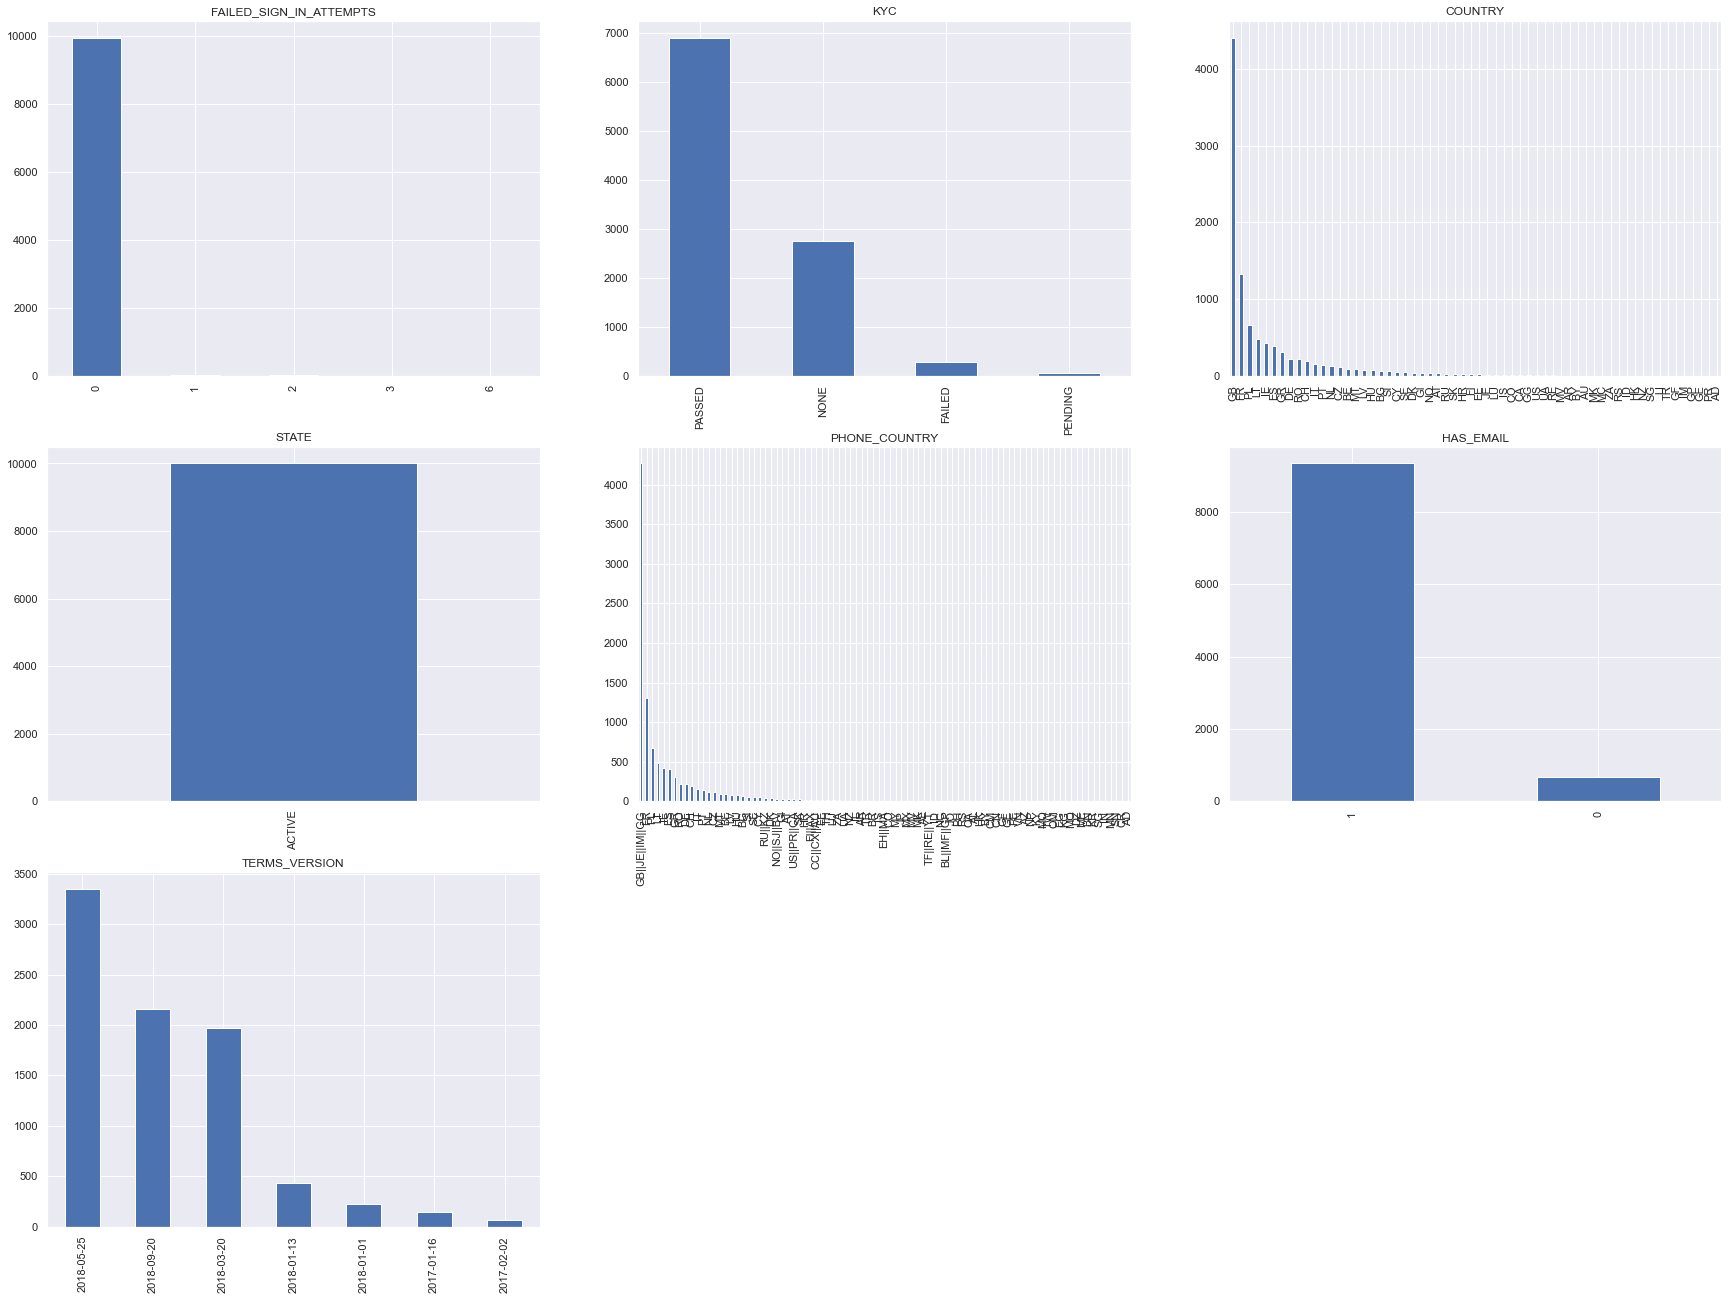

In [27]:
plt.subplot(431)
df_nf_users['FAILED_SIGN_IN_ATTEMPTS'].value_counts(normalize=False).plot.bar(figsize=(30,30), title= 'FAILED_SIGN_IN_ATTEMPTS')

plt.subplot(432)
df_nf_users['KYC'].value_counts(normalize=False).plot.bar(title= 'KYC')

plt.subplot(433)
df_nf_users['COUNTRY'].value_counts(normalize=False).plot.bar(title= 'COUNTRY')

plt.subplot(434)
df_nf_users['STATE'].value_counts(normalize=False).plot.bar(title= 'STATE')

plt.subplot(435)
df_nf_users['PHONE_COUNTRY'].value_counts(normalize=False).plot.bar(title= 'PHONE_COUNTRY')

plt.subplot(436)
df_nf_users['HAS_EMAIL'].value_counts(normalize=False).plot.bar(title= 'HAS_EMAIL')

plt.subplot(437)
df_nf_users['TERMS_VERSION'].value_counts(normalize=False).plot.bar(title= 'TERMS_VERSION')



In [28]:

# We can see that most of the fraud users are from country "GB" and have a related phone_country
# But, the normal user data shows that majority of users are from GB 
# So, nothing can be firmly said about fraudsters just by looking at users data 


In [29]:
# Let's now have a look at other important table which is transactions table for fraud users 


In [30]:
df_fraud_user_txns = pd.merge(df_transactions, df_fraudsters, how='inner', left_on='USER_ID', right_on='user_id')

In [31]:
df_fraud_user_txns.head()

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
0,1383,GBP,40100,FAILED,2015-09-07 20:35:47.397000,NaN,NaN,misc,36c414e8-da9c-4c38-9a01-e0932263a300,TOPUP,NYX,0f6613a3-21b5-43ab-aac1-8706cd101f33,64,36c414e8-da9c-4c38-9a01-e0932263a300
1,1385,GBP,40100,FAILED,2015-09-07 20:35:15.094000,NaN,NaN,misc,36c414e8-da9c-4c38-9a01-e0932263a300,TOPUP,NYX,5e08b797-eef9-4e5e-91b2-614d3c348ff0,64,36c414e8-da9c-4c38-9a01-e0932263a300
2,1386,GBP,40100,FAILED,2015-09-07 20:14:04.286000,NaN,NaN,misc,36c414e8-da9c-4c38-9a01-e0932263a300,TOPUP,NYX,17523e4d-1c16-426c-8f88-7cb5730cd9ac,64,36c414e8-da9c-4c38-9a01-e0932263a300
3,1395,GBP,40200,FAILED,2015-09-07 20:29:12.632000,NaN,NaN,misc,36c414e8-da9c-4c38-9a01-e0932263a300,TOPUP,NYX,29e137f7-7e07-450f-a99b-362d401adb61,64,36c414e8-da9c-4c38-9a01-e0932263a300
4,1400,GBP,40000,FAILED,2015-09-07 19:56:49.147000,NaN,NaN,misc,36c414e8-da9c-4c38-9a01-e0932263a300,TOPUP,NYX,27af5834-5578-4f07-9dca-15054b731cd6,64,36c414e8-da9c-4c38-9a01-e0932263a300


<AxesSubplot:title={'center':'SOURCE'}>

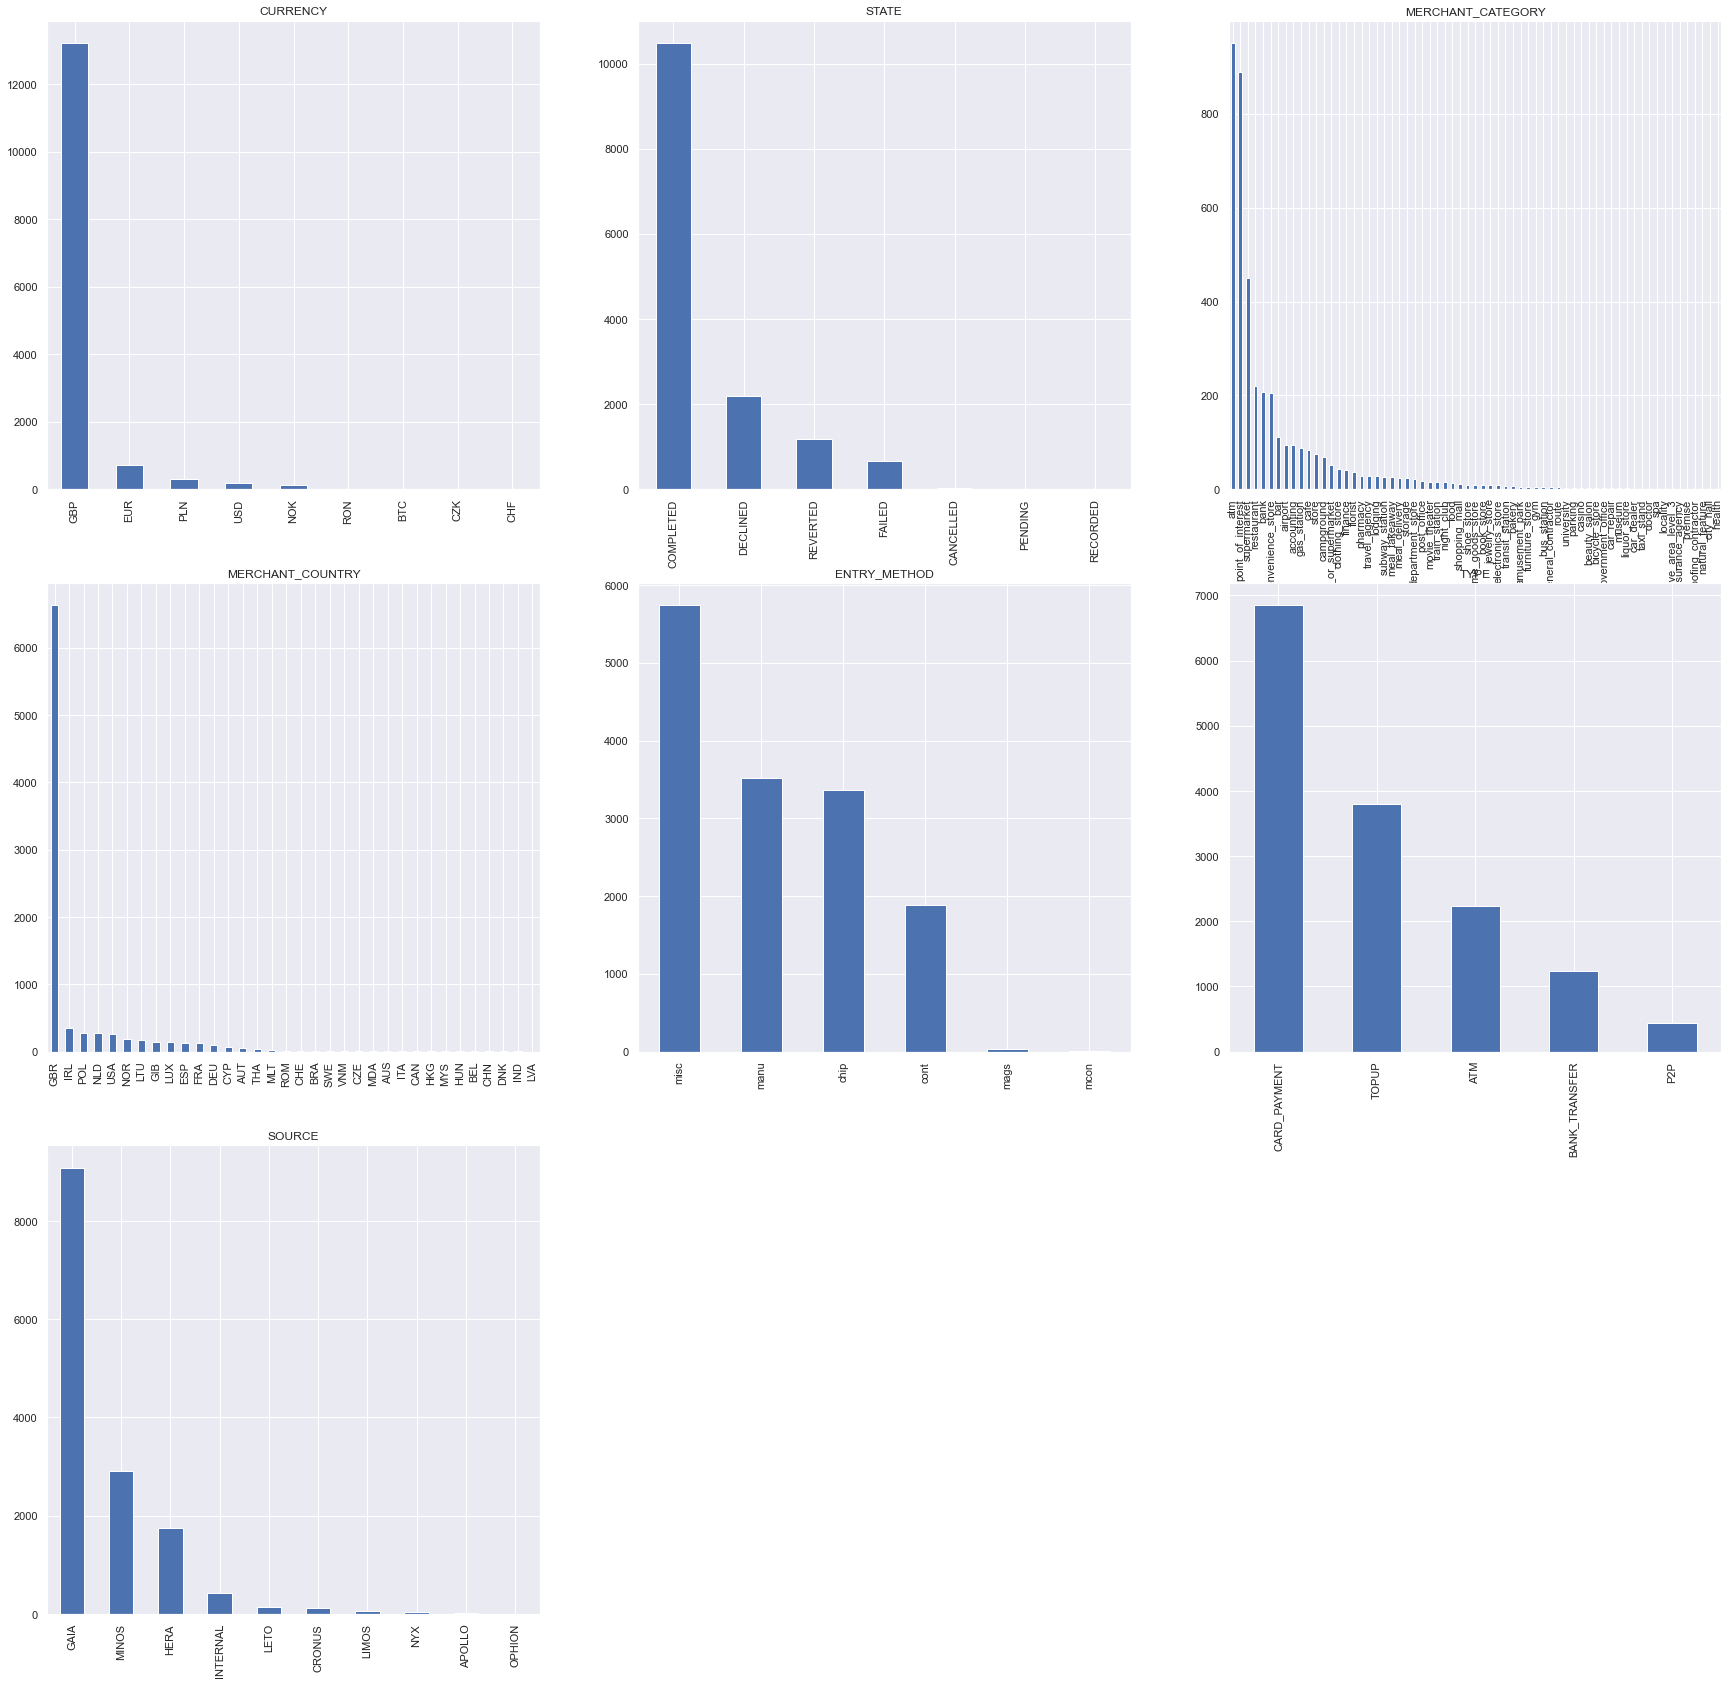

In [32]:
plt.subplot(531)
df_fraud_user_txns['CURRENCY'].value_counts(normalize=False).plot.bar(figsize=(30,50), title= 'CURRENCY')

plt.subplot(532)
df_fraud_user_txns['STATE'].value_counts(normalize=False).plot.bar(title= 'STATE')

plt.subplot(533)
df_fraud_user_txns['MERCHANT_CATEGORY'].value_counts(normalize=False).plot.bar(title= 'MERCHANT_CATEGORY')

plt.subplot(534)
df_fraud_user_txns['MERCHANT_COUNTRY'].value_counts(normalize=False).plot.bar(title= 'MERCHANT_COUNTRY')

plt.subplot(535)
df_fraud_user_txns['ENTRY_METHOD'].value_counts(normalize=False).plot.bar(title= 'ENTRY_METHOD')

plt.subplot(536)
df_fraud_user_txns['TYPE'].value_counts(normalize=False).plot.bar(title= 'TYPE')

plt.subplot(537)
df_fraud_user_txns['SOURCE'].value_counts(normalize=False).plot.bar(title= 'SOURCE')


In [33]:
# mostly non fraud user transactions
df_nf_txns = pd.merge(df_transactions, df_fraudsters, how='left', left_on='USER_ID', right_on='user_id')
df_nf_txns = df_nf_txns[pd.isnull(df_nf_txns["user_id"])]

In [34]:
df_nf_txns.head()

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
0,0,GBP,3738,COMPLETED,2015-10-11 09:05:43.016000,bar,AUS,misc,7285c1ec-31d0-4022-b311-0ad9227ef7f4,CARD_PAYMENT,GAIA,5a9ee109-e9b3-4598-8dd7-587591e6a470,NaN,NaN
1,1,GBP,588,COMPLETED,2015-10-11 20:08:39.150000,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,28d68bf4-460b-4c8e-9b95-bcda9ab596b5,NaN,NaN
2,2,GBP,1264,COMPLETED,2015-10-11 11:37:40.908000,NaN,UKR,misc,0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0,CARD_PAYMENT,GAIA,1f1e8817-d40b-4c09-b718-cfc4a6f211df,NaN,NaN
3,3,GBP,66,REVERTED,2015-10-11 20:08:35.310000,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,a7aaf78c-d201-456f-9e6d-612a795e8c32,NaN,NaN
4,4,GBP,968,COMPLETED,2015-10-11 02:46:47.640000,supermarket,NZL,misc,821014c5-af06-40ff-91f4-77fe7667809f,CARD_PAYMENT,GAIA,27dd99a2-5539-4ba9-876a-1a94abc2701f,NaN,NaN


<AxesSubplot:title={'center':'SOURCE'}>

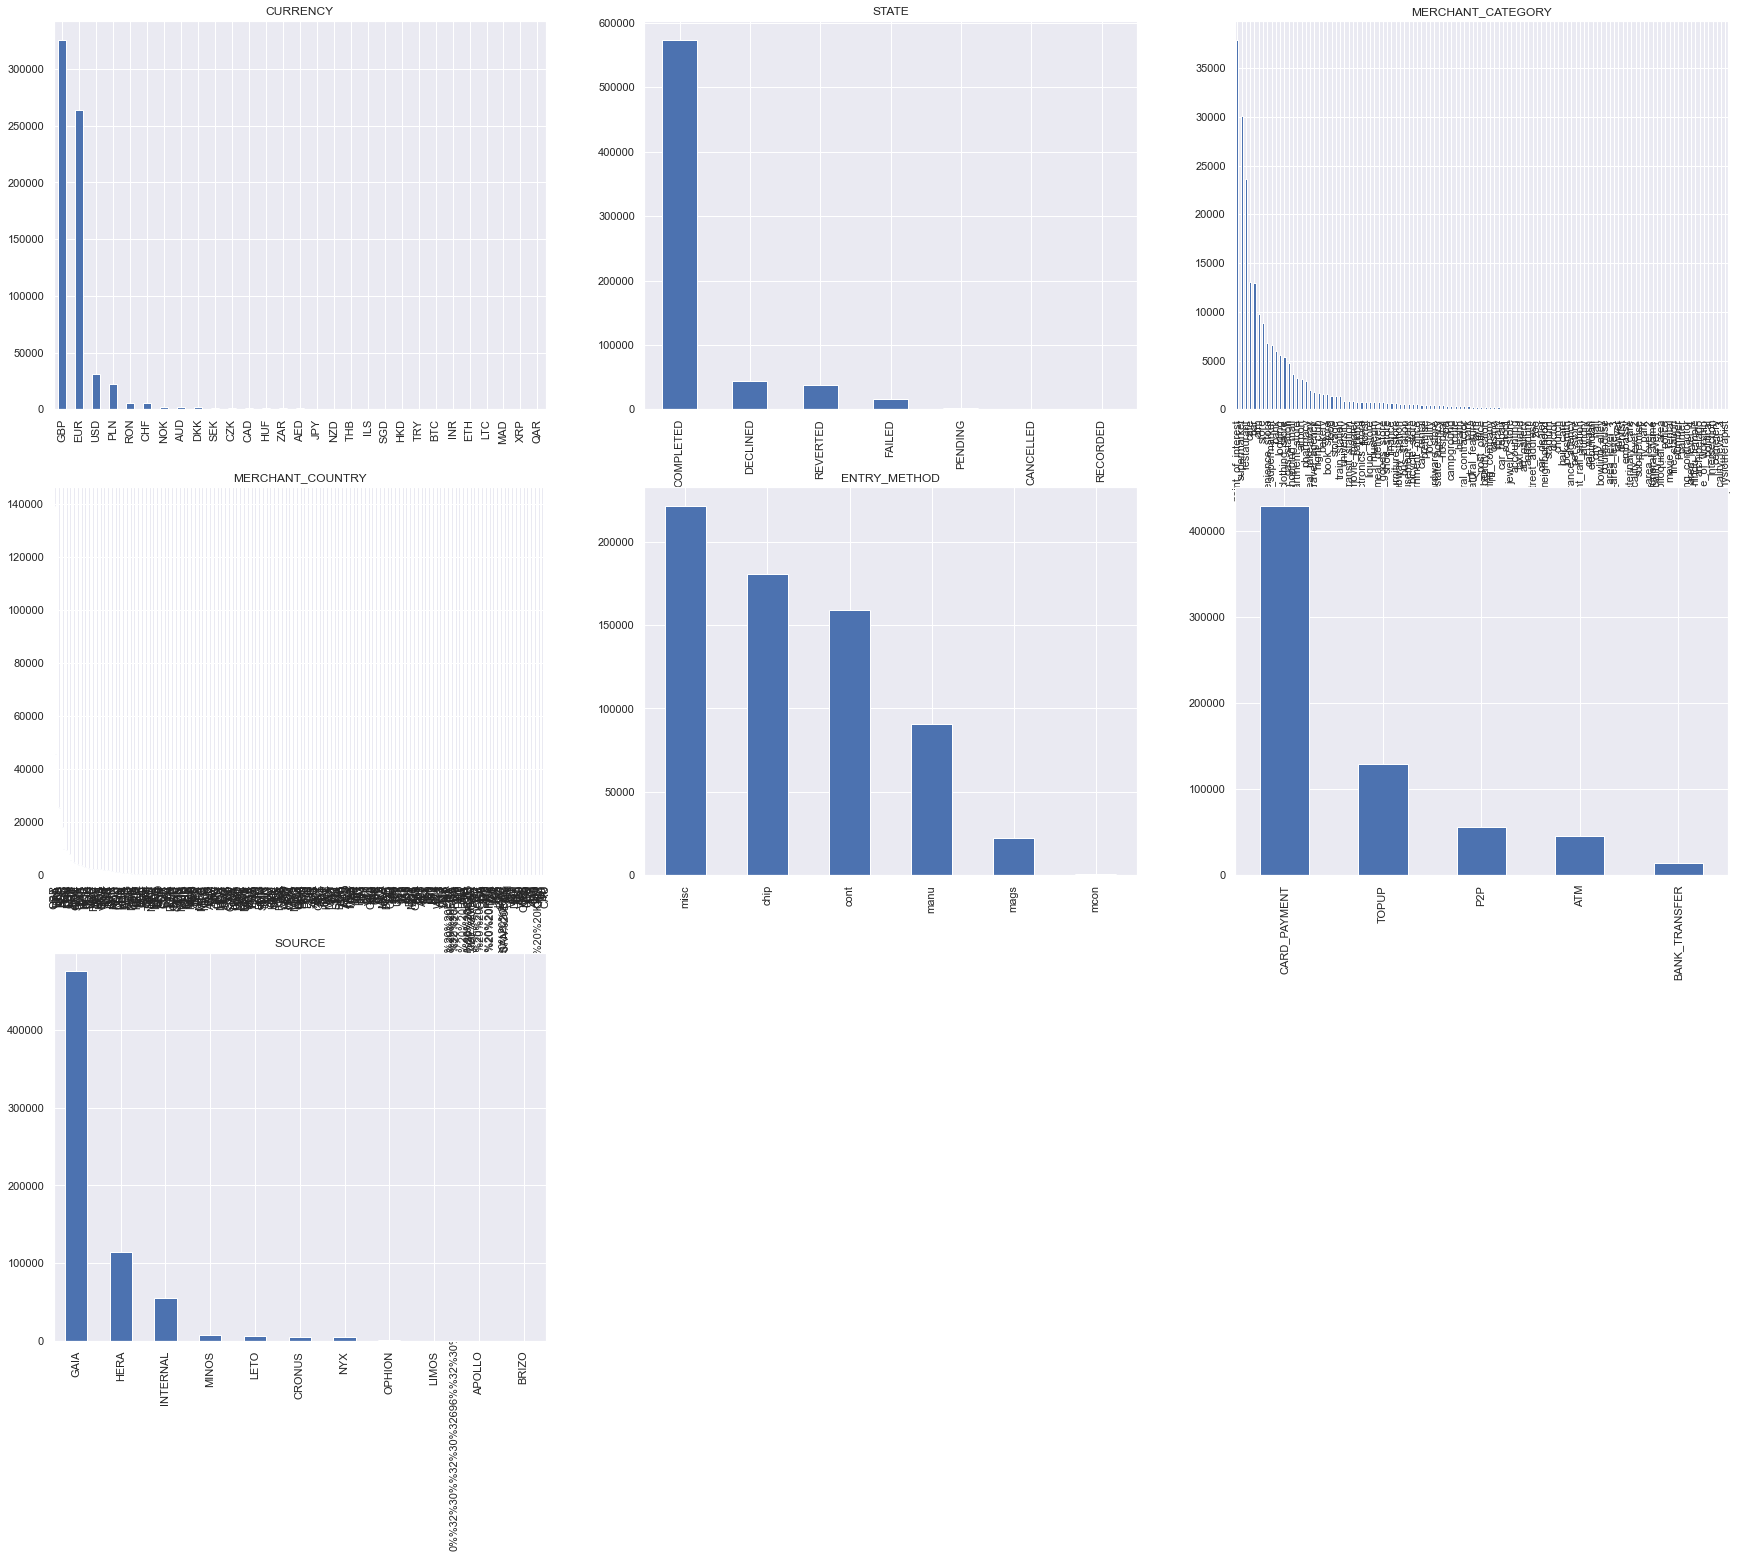

In [35]:
plt.subplot(631)
df_nf_txns['CURRENCY'].value_counts(normalize=False).plot.bar(figsize=(30,50), title= 'CURRENCY')

plt.subplot(632)
df_nf_txns['STATE'].value_counts(normalize=False).plot.bar(title= 'STATE')

plt.subplot(633)
df_nf_txns['MERCHANT_CATEGORY'].value_counts(normalize=False).plot.bar(title= 'MERCHANT_CATEGORY')

plt.subplot(634)
df_nf_txns['MERCHANT_COUNTRY'].value_counts(normalize=False).plot.bar(title= 'MERCHANT_COUNTRY')

plt.subplot(635)
df_nf_txns['ENTRY_METHOD'].value_counts(normalize=False).plot.bar(title= 'ENTRY_METHOD')

plt.subplot(636)
df_nf_txns['TYPE'].value_counts(normalize=False).plot.bar(title= 'TYPE')

plt.subplot(637)
df_nf_txns['SOURCE'].value_counts(normalize=False).plot.bar(title= 'SOURCE')

In [36]:
# Again the transactions data for fraud and non fraud users shows nothing conclusive as
## for each the params the data spreads over all the distinct set

# Bascially, a fraud user also has some valid transactions recorded till the fraud happened 

# So, now we will have to look at each fraud users transactions and try to identify which are the fraud records
## spending pattern , suspicious column values for some transactions , 
## multiple outlier transactions within the same time frame etc



In [37]:
df_fraudsters.head(50) # randomly sample few fraud user transactions 

,Unnamed: 0,user_id
0,0,5270b0f4-2e4a-4ec9-8648-2135312ac1c4
1,1,848fc1b1-096c-40f7-b04a-1399c469e421
2,2,27c76eda-e159-4df3-845a-e13f4e28a8b5
3,3,a27088ef-9452-403d-9bbb-f7b10180cdda
4,4,fb23710b-609a-49bf-8a9a-be49c59ce6de
5,5,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b
6,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
7,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a
8,8,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec
9,9,7377f2fc-4585-49e8-8896-df332efc51c8


In [38]:
# Sample fraud transaction data for a user
df_fraud_user_txns[df_fraud_user_txns['user_id'] == '848fc1b1-096c-40f7-b04a-1399c469e421'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
14435,599236,GBP,59700,COMPLETED,2018-06-29 12:34:41.413000,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,TOPUP,MINOS,062feaed-978a-4e04-b167-accf58d4f51e,1,848fc1b1-096c-40f7-b04a-1399c469e421
14436,600652,GBP,10000,COMPLETED,2018-06-29 16:22:12.830000,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,BANK_TRANSFER,MINOS,0baebd76-a069-46a0-b566-2b3c98779415,1,848fc1b1-096c-40f7-b04a-1399c469e421
14437,608847,GBP,10000,COMPLETED,2018-07-01 13:56:12.490000,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,BANK_TRANSFER,CRONUS,a40d8b2a-8f54-4422-b8e3-9d6fc485b6a6,1,848fc1b1-096c-40f7-b04a-1399c469e421
14440,660610,GBP,16100,COMPLETED,2018-07-01 14:02:48.784000,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,P2P,INTERNAL,81d3ed83-3105-4db2-99b7-716a3c9e378e,1,848fc1b1-096c-40f7-b04a-1399c469e421
14438,609296,GBP,10000,COMPLETED,2018-07-02 20:02:34.118000,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,BANK_TRANSFER,MINOS,cb6d9f7c-f53b-40c7-9cde-e9925bb2f704,1,848fc1b1-096c-40f7-b04a-1399c469e421
14439,623021,GBP,1000,DECLINED,2018-07-07 12:18:43.854000,NaN,GBR,chip,848fc1b1-096c-40f7-b04a-1399c469e421,ATM,GAIA,0d5adf49-9013-47c2-a39e-aef16567eea7,1,848fc1b1-096c-40f7-b04a-1399c469e421


In [39]:
# sample user profile data for a fraud account
df_users[df_users["ID"]== '848fc1b1-096c-40f7-b04a-1399c469e421']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8452,8452,0,PASSED,1994,GB,LOCKED,2018-06-16 15:55:43.800000,2018-05-25,PL,1,848fc1b1-096c-40f7-b04a-1399c469e421


In [40]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == '27c76eda-e159-4df3-845a-e13f4e28a8b5'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
13254,477938,GBP,100,REVERTED,2018-05-11 23:54:58.080000,NaN,NaN,misc,27c76eda-e159-4df3-845a-e13f4e28a8b5,TOPUP,HERA,84fd9620-c389-43f2-be75-37b558c88407,2,27c76eda-e159-4df3-845a-e13f4e28a8b5
13255,601218,GBP,1000,COMPLETED,2018-05-11 23:55:49.511000,NaN,NaN,misc,27c76eda-e159-4df3-845a-e13f4e28a8b5,TOPUP,HERA,ad98685d-dda8-471e-b718-1612dfa56c1e,2,27c76eda-e159-4df3-845a-e13f4e28a8b5


In [41]:
df_users[df_users["ID"]== '27c76eda-e159-4df3-845a-e13f4e28a8b5']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8453,8453,0,PASSED,1997,GB,LOCKED,2018-05-11 18:20:45.608000,2018-05-25,GB||JE||IM||GG,1,27c76eda-e159-4df3-845a-e13f4e28a8b5


In [42]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == 'a27088ef-9452-403d-9bbb-f7b10180cdda'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
13562,502228,USD,100,FAILED,2018-05-22 12:05:46.046000,NaN,NaN,misc,a27088ef-9452-403d-9bbb-f7b10180cdda,TOPUP,HERA,bd118375-95c1-490c-abaf-4feb8c690fb4,3,a27088ef-9452-403d-9bbb-f7b10180cdda
13564,601574,GBP,57700,COMPLETED,2018-06-29 15:19:20.464000,NaN,NaN,misc,a27088ef-9452-403d-9bbb-f7b10180cdda,TOPUP,MINOS,6cea5908-b8d9-41c7-9827-4e10a2adb11a,3,a27088ef-9452-403d-9bbb-f7b10180cdda
13563,601284,GBP,55000,COMPLETED,2018-06-29 15:21:11.356000,NaN,NaN,misc,a27088ef-9452-403d-9bbb-f7b10180cdda,BANK_TRANSFER,MINOS,2b0d3fee-91a4-44a4-808b-76b57825391a,3,a27088ef-9452-403d-9bbb-f7b10180cdda
13565,603782,GBP,1286,COMPLETED,2018-06-29 21:11:01.185000,NaN,NaN,misc,a27088ef-9452-403d-9bbb-f7b10180cdda,BANK_TRANSFER,MINOS,991ac3ee-3762-4174-a84b-e647eb1d287c,3,a27088ef-9452-403d-9bbb-f7b10180cdda


In [43]:
df_users[df_users["ID"]== 'a27088ef-9452-403d-9bbb-f7b10180cdda']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8454,8454,0,PASSED,1989,BE,LOCKED,2018-05-18 16:41:12.267000,2018-05-25,IN,1,a27088ef-9452-403d-9bbb-f7b10180cdda


In [44]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == 'fb23710b-609a-49bf-8a9a-be49c59ce6de'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
11904,405937,GBP,5000,COMPLETED,2018-04-06 18:43:33.955000,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,TOPUP,MINOS,961f9451-2d7d-4c62-8593-bf44d15d38b0,4,fb23710b-609a-49bf-8a9a-be49c59ce6de
11905,405957,GBP,4709,COMPLETED,2018-04-06 18:53:35.634000,point_of_interest,LTU,manu,fb23710b-609a-49bf-8a9a-be49c59ce6de,CARD_PAYMENT,GAIA,953623dd-4d61-4f1a-b760-13fda4217b3b,4,fb23710b-609a-49bf-8a9a-be49c59ce6de
11906,416491,GBP,6500,COMPLETED,2018-04-09 14:53:30.372000,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,TOPUP,MINOS,eb2c9e9d-bffc-4347-9d86-28b6f0dea32d,4,fb23710b-609a-49bf-8a9a-be49c59ce6de
11907,416732,GBP,6000,COMPLETED,2018-04-09 17:23:08.928000,NaN,NaN,misc,fb23710b-609a-49bf-8a9a-be49c59ce6de,P2P,INTERNAL,823e2403-eee1-4c74-beae-c53fdffdaae0,4,fb23710b-609a-49bf-8a9a-be49c59ce6de


In [45]:
df_users[df_users["ID"]== 'fb23710b-609a-49bf-8a9a-be49c59ce6de']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8455,8455,0,PASSED,1992,LT,LOCKED,2018-03-29 13:37:29.736000,2018-03-20,LT,1,fb23710b-609a-49bf-8a9a-be49c59ce6de


In [46]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == '3a1e97cd-69a7-4c68-a98c-e0d7d606b07b'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
13067,445664,GBP,100,REVERTED,2018-04-29 16:33:39.564000,NaN,NaN,misc,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b,TOPUP,HERA,c7467564-5fe1-4cb8-91c2-81cac6b3245a,5,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b
13066,445574,GBP,1000,COMPLETED,2018-04-29 16:34:08.402000,NaN,NaN,misc,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b,TOPUP,HERA,dc47f7c4-bde5-4424-a584-f2461fc41ab9,5,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b
13068,450138,GBP,270,COMPLETED,2018-05-01 19:59:29.254000,supermarket,GBR,chip,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b,CARD_PAYMENT,GAIA,655003ea-b911-45d3-901a-12172e548ad2,5,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b
13069,455175,GBP,299,DECLINED,2018-05-03 14:08:35.340000,supermarket,GBR,cont,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b,CARD_PAYMENT,GAIA,ce3bf2e3-c391-466b-839d-2e6c30300201,5,3a1e97cd-69a7-4c68-a98c-e0d7d606b07b


In [47]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == 'e7b6e022-76ca-4fe9-992e-0773a4715b0c'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
9772,341289,GBP,100,REVERTED,2018-02-22 11:14:54.620000,NaN,NaN,misc,e7b6e022-76ca-4fe9-992e-0773a4715b0c,TOPUP,HERA,fb776d09-1e27-4fdc-bf49-f18c86558bd0,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9771,341288,GBP,1000,COMPLETED,2018-02-22 11:15:31.913000,NaN,NaN,misc,e7b6e022-76ca-4fe9-992e-0773a4715b0c,TOPUP,HERA,abfedca2-3dcf-44f1-a6db-89480591a8d2,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9773,346034,GBP,100,COMPLETED,2018-02-23 16:27:11.214000,NaN,GBR,chip,e7b6e022-76ca-4fe9-992e-0773a4715b0c,CARD_PAYMENT,GAIA,f9a67741-c350-43e5-b18c-8c38b3544566,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9770,340212,GBP,0,REVERTED,2018-02-25 12:39:28.301000,NaN,GBR,manu,e7b6e022-76ca-4fe9-992e-0773a4715b0c,CARD_PAYMENT,GAIA,0e5654d4-8f63-4e22-bf9f-61a1d4ddf6ed,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9774,405577,GBP,10,DECLINED,2018-04-03 21:44:00.536000,NaN,GBR,manu,e7b6e022-76ca-4fe9-992e-0773a4715b0c,CARD_PAYMENT,GAIA,1f5570d7-faf0-48c9-81dd-9de7588b697f,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c


In [48]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == 'e7876b06-bcd8-4193-9eaa-b477313f6f1a'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
13903,551640,GBP,6600,COMPLETED,2018-06-12 11:50:03.366000,NaN,NaN,misc,e7876b06-bcd8-4193-9eaa-b477313f6f1a,TOPUP,MINOS,a0ed887e-0a32-4eb4-bcb2-de3c350b57fe,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a
13907,562831,GBP,6521,COMPLETED,2018-06-12 11:53:08.740000,point_of_interest,LTU,manu,e7876b06-bcd8-4193-9eaa-b477313f6f1a,CARD_PAYMENT,GAIA,7cf1d538-0945-4fae-a308-4b74fef556ae,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a
13905,556249,GBP,5500,COMPLETED,2018-06-14 20:45:55.005000,NaN,NaN,misc,e7876b06-bcd8-4193-9eaa-b477313f6f1a,TOPUP,MINOS,17c82dbb-a71a-44e0-a579-f771f6ea0c6d,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a
13908,568643,GBP,4363,COMPLETED,2018-06-14 21:02:07.051000,point_of_interest,LTU,manu,e7876b06-bcd8-4193-9eaa-b477313f6f1a,CARD_PAYMENT,GAIA,d7ccfc10-5d0d-4dce-b2f2-37647e3bd071,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a
13904,555902,GBP,437,DECLINED,2018-06-14 23:14:33.732000,point_of_interest,LTU,manu,e7876b06-bcd8-4193-9eaa-b477313f6f1a,CARD_PAYMENT,GAIA,20780550-9e3d-4df3-b9f6-eeae4310b897,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a
13906,557704,EUR,500,DECLINED,2018-06-15 13:28:33.243000,point_of_interest,LTU,manu,e7876b06-bcd8-4193-9eaa-b477313f6f1a,CARD_PAYMENT,GAIA,4a77f6a6-842a-4c94-860a-842afffce277,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a
13909,568645,GBP,482,COMPLETED,2018-06-15 13:30:07.328000,point_of_interest,LTU,manu,e7876b06-bcd8-4193-9eaa-b477313f6f1a,CARD_PAYMENT,GAIA,23b935da-9e66-45ce-b390-9daf4629b0f0,7,e7876b06-bcd8-4193-9eaa-b477313f6f1a


In [49]:
df_users[df_users["ID"]== 'e7876b06-bcd8-4193-9eaa-b477313f6f1a']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8458,8458,0,PASSED,1978,LT,LOCKED,2018-06-11 14:58:25.637000,2018-05-25,LT,1,e7876b06-bcd8-4193-9eaa-b477313f6f1a


In [50]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == '5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
9778,344069,GBP,100,REVERTED,2018-02-25 09:03:58.477000,NaN,NaN,misc,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec,TOPUP,HERA,9a520818-8b55-44aa-9112-86e9c3b4d8b7,8,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec
9777,344068,GBP,1000,COMPLETED,2018-02-25 09:04:11.685000,NaN,NaN,misc,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec,TOPUP,HERA,ea0022eb-b194-4329-8f9e-6cc7b2c09882,8,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec
9775,340743,GBP,110000,COMPLETED,2018-02-25 19:43:42.836000,NaN,NaN,misc,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec,TOPUP,MINOS,acd34f1c-270a-409b-a752-b9fdfdd25e7e,8,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec
9776,340797,GBP,111000,COMPLETED,2018-02-25 20:07:24.105000,NaN,NaN,misc,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec,BANK_TRANSFER,MINOS,b0a98a92-b980-4bd9-a39a-63a36b16602d,8,5b6f20a3-b39a-4f1b-bc5a-974daab4d2ec


In [51]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == '7377f2fc-4585-49e8-8896-df332efc51c8'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
4085,162456,GBP,100,FAILED,2017-08-11 12:13:09.818000,NaN,NaN,misc,7377f2fc-4585-49e8-8896-df332efc51c8,TOPUP,HERA,27676a14-46b5-4f88-8d7b-2f11f339cbdc,9,7377f2fc-4585-49e8-8896-df332efc51c8
4084,162455,GBP,100,REVERTED,2017-08-11 12:13:59.239000,NaN,NaN,misc,7377f2fc-4585-49e8-8896-df332efc51c8,TOPUP,HERA,21eb43b1-585d-4c58-8d04-e155e89eb1b4,9,7377f2fc-4585-49e8-8896-df332efc51c8
4083,162454,GBP,1700,COMPLETED,2017-08-11 12:14:13.849000,NaN,NaN,misc,7377f2fc-4585-49e8-8896-df332efc51c8,TOPUP,HERA,ce881b1b-0f8f-4efe-8968-a679b50f54ab,9,7377f2fc-4585-49e8-8896-df332efc51c8
4086,162460,GBP,1700,COMPLETED,2017-08-11 12:26:09.850000,point_of_interest,GIB,manu,7377f2fc-4585-49e8-8896-df332efc51c8,CARD_PAYMENT,GAIA,27f71d11-62c1-4d3c-affe-5a8bd0c4193b,9,7377f2fc-4585-49e8-8896-df332efc51c8


In [52]:
df_users[df_users['ID'] == '7377f2fc-4585-49e8-8896-df332efc51c8']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8460,8460,0,PASSED,1998,GB,LOCKED,2016-04-07 12:45:30.913000,NaN,GB||JE||IM||GG,1,7377f2fc-4585-49e8-8896-df332efc51c8


In [53]:
df_users[df_users['ID'] == '7377f2fc-4585-49e8-8896-df332efc51c8']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8460,8460,0,PASSED,1998,GB,LOCKED,2016-04-07 12:45:30.913000,NaN,GB||JE||IM||GG,1,7377f2fc-4585-49e8-8896-df332efc51c8


In [54]:
df_fraud_users[df_fraud_users['KYC'] == "NONE"]

,Unnamed: 0_x,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID,Unnamed: 0_y,user_id
0,8451,0,NONE,1988,GB,LOCKED,2017-09-19 01:55:22.376000,NaN,GB||JE||IM||GG,1,5270b0f4-2e4a-4ec9-8648-2135312ac1c4,0,5270b0f4-2e4a-4ec9-8648-2135312ac1c4


In [55]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == 'e7b6e022-76ca-4fe9-992e-0773a4715b0c'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
9772,341289,GBP,100,REVERTED,2018-02-22 11:14:54.620000,NaN,NaN,misc,e7b6e022-76ca-4fe9-992e-0773a4715b0c,TOPUP,HERA,fb776d09-1e27-4fdc-bf49-f18c86558bd0,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9771,341288,GBP,1000,COMPLETED,2018-02-22 11:15:31.913000,NaN,NaN,misc,e7b6e022-76ca-4fe9-992e-0773a4715b0c,TOPUP,HERA,abfedca2-3dcf-44f1-a6db-89480591a8d2,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9773,346034,GBP,100,COMPLETED,2018-02-23 16:27:11.214000,NaN,GBR,chip,e7b6e022-76ca-4fe9-992e-0773a4715b0c,CARD_PAYMENT,GAIA,f9a67741-c350-43e5-b18c-8c38b3544566,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9770,340212,GBP,0,REVERTED,2018-02-25 12:39:28.301000,NaN,GBR,manu,e7b6e022-76ca-4fe9-992e-0773a4715b0c,CARD_PAYMENT,GAIA,0e5654d4-8f63-4e22-bf9f-61a1d4ddf6ed,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c
9774,405577,GBP,10,DECLINED,2018-04-03 21:44:00.536000,NaN,GBR,manu,e7b6e022-76ca-4fe9-992e-0773a4715b0c,CARD_PAYMENT,GAIA,1f5570d7-faf0-48c9-81dd-9de7588b697f,6,e7b6e022-76ca-4fe9-992e-0773a4715b0c


In [56]:
df_users[df_users['ID'] == 'e7b6e022-76ca-4fe9-992e-0773a4715b0c']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
8457,8457,0,PENDING,1997,GB,LOCKED,2017-08-16 15:14:31.950000,2018-03-20,GB||JE||IM||GG,1,e7b6e022-76ca-4fe9-992e-0773a4715b0c


In [57]:
# a non fraud user transaction data 
df_transactions[df_transactions["USER_ID"] == '20100a1d-12bc-41ed-a5e1-bc46216e9696'].sort_values(by="CREATED_DATE", ascending=False)

,Unnamed: 0,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
443331,456897,GBP,10000,FAILED,2018-05-06 16:31:37.935000,NaN,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,TOPUP,HERA,a9794e8c-493e-48de-831f-ab3afae9ad89
443332,456898,GBP,584,COMPLETED,2018-05-06 16:31:37.590000,NaN,NLD,manu,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,c6ac140a-e578-4dc0-ac09-cbe3390ab007
443592,457158,GBP,10000,FAILED,2018-05-06 16:18:43.822000,NaN,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,TOPUP,HERA,742f0a9c-d132-4569-9a6d-c8d799928436
443593,457159,GBP,0,REVERTED,2018-05-06 16:18:43.478000,NaN,NLD,manu,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,38e8e0f5-280d-4b77-b314-9797c5770d4d
430941,444207,GBP,10000,FAILED,2018-04-27 20:52:23.607000,NaN,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,TOPUP,HERA,e8979e01-3c3f-456a-9c6f-2a6dde1a9be0
...,...,...,...,...,...,...,...,...,...,...,...,...
444,444,GBP,3000,COMPLETED,2015-10-02 19:19:09.424000,NaN,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,P2P,INTERNAL,ce8e7565-ed55-4fdb-96a7-e37b7bfd0546
572,572,GBP,5000,COMPLETED,2015-10-02 18:23:50.571000,NaN,GBR,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,ATM,GAIA,2a14dad4-2c05-4483-833b-cbc50e2dddef
449,449,GBP,20000,COMPLETED,2015-10-02 17:15:07.745000,NaN,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,TOPUP,OPHION,2b3080c1-47e3-4248-a6b1-8addf7a5c66a
703,703,GBP,852,COMPLETED,2015-09-28 21:15:08.577000,NaN,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,TOPUP,OPHION,ef01b20b-009b-43c6-9e1d-5b68717499e8


In [58]:
df_users[df_users['ID'] == '20100a1d-12bc-41ed-a5e1-bc46216e9696']

,Unnamed: 0,FAILED_SIGN_IN_ATTEMPTS,KYC,BIRTH_YEAR,COUNTRY,STATE,CREATED_DATE,TERMS_VERSION,PHONE_COUNTRY,HAS_EMAIL,ID
9031,9230,0,PASSED,1988,GB,ACTIVE,2015-09-25 21:38:40.670000,2018-05-25,GB||JE||IM||GG,1,20100a1d-12bc-41ed-a5e1-bc46216e9696


In [59]:
# High deviation from normal expenditure for fraud user transactions

df_fraud_user_txns[df_fraud_user_txns['user_id'] == '0238733a-732b-4353-a463-20fc1868affd'].sort_values(by="CREATED_DATE").describe()


,Unnamed: 0_x,AMOUNT,Unnamed: 0_y
count,6.000000,6.000000,6.0
mean,324335.833333,23758.166667,34.0
std,148095.466298,39362.418373,0.0
min,226906.000000,100.000000,34.0
25%,236003.750000,325.000000,34.0
50%,280427.000000,1000.000000,34.0
75%,309556.250000,33886.750000,34.0
max,617793.000000,95500.000000,34.0


In [60]:
df_fraud_user_txns[df_fraud_user_txns['user_id'] == '069593ee-a4b1-4b1c-ad96-bd2b61c0c263'].sort_values(by="CREATED_DATE")

,Unnamed: 0_x,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,Unnamed: 0_y,user_id
10527,358692,GBP,25000,COMPLETED,2018-03-07 13:44:42.117000,NaN,NaN,misc,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,TOPUP,MINOS,58a24e99-a383-42e6-b4f9-ebfb2488e4f1,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10528,358987,GBP,25000,COMPLETED,2018-03-07 16:31:16.814000,NaN,NaN,misc,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,BANK_TRANSFER,MINOS,cad5738c-94f3-4f38-94ca-e0c71a91899a,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10537,660603,GBP,18400,COMPLETED,2018-03-19 21:44:41.047000,NaN,NaN,misc,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,TOPUP,MINOS,ba26e7c1-c97b-4da6-89c8-d05746c8895e,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10533,379180,GBP,0,REVERTED,2018-03-19 22:23:10.213000,NaN,AUT,manu,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,CARD_PAYMENT,GAIA,2e9ba88d-9965-4813-8b1f-5f1b753b989b,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10532,379179,GBP,2190,COMPLETED,2018-03-19 22:23:59.320000,NaN,AUT,manu,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,CARD_PAYMENT,GAIA,4af9d3b6-7e9f-4324-988e-d3a6d0a5a917,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10531,379117,GBP,0,REVERTED,2018-03-19 23:06:41.111000,NaN,AUT,manu,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,CARD_PAYMENT,GAIA,609f569e-4f46-475d-b7c2-03a7d8164b1c,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10530,379115,GBP,14890,COMPLETED,2018-03-19 23:07:28.105000,NaN,AUT,manu,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,CARD_PAYMENT,GAIA,e410c980-6b17-4ca3-b0e2-b3d1321cf820,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10529,376847,GBP,100,COMPLETED,2018-03-21 19:49:29.253000,NaN,NaN,misc,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,BANK_TRANSFER,MINOS,492501f2-1e40-4e4b-b346-8202f104ee9e,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10535,386352,GBP,100,REVERTED,2018-03-25 17:16:18.530000,NaN,NaN,misc,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,TOPUP,HERA,3d90da9f-e313-4496-98d3-01ad28e44d3a,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263
10534,386299,GBP,1000,REVERTED,2018-03-25 17:16:57.484000,NaN,NaN,misc,069593ee-a4b1-4b1c-ad96-bd2b61c0c263,TOPUP,HERA,bb338731-0831-4eaf-89ed-bde9d40923de,37,069593ee-a4b1-4b1c-ad96-bd2b61c0c263


In [61]:
df_transactions[df_transactions["USER_ID"] == '069593ee-a4b1-4b1c-ad96-bd2b61c0c263'].sort_values(by="CREATED_DATE").describe()

,Unnamed: 0,AMOUNT
count,11.000000,11.000000
mean,402796.909091,7970.909091
std,86052.718162,10574.492380
min,358692.000000,0.000000
25%,377981.000000,100.000000
50%,379179.000000,1000.000000
75%,386325.500000,16645.000000
max,660603.000000,25000.000000


In [62]:
# Observation 

## Most of the fraud user transaction data has some outlier transaction for some big amount which isnt normal
## For most the fraud user profiles, the fraudster has tried multiple fraud transactions within a short time frame
## And most of the fraud transactions have merchant_category, merchant_country as null or not matching
## and entry_method as misc- unknown or manual

In [63]:
# To find fraud transactions for a user profile

## We will first try to find if any outlier transaction has happened,
## with multiple hits on same day and suspicious params

## To find the outlier transaction we will first convert all transaction amounts to USD,
## We will then use Inter Quarlite Range for outlier detection, max > IQ3 + 1.5*IQR

In [64]:
# Let's code the same and run all non fraud users transactions to find some fraud profiles

In [65]:
predicted_fraud_users = []

def convert_to_usd(row):
    row_amount = row['AMOUNT']
    cur_det = df_currency_details[df_currency_details['currency']== row['CURRENCY']].iloc[0]
    row_amount = row_amount / pow(10, cur_det.exponent)
    
    if row['CURRENCY'] != 'USD':
        fx_rates = df_fx_rates[df_fx_rates['ccy'] == row['CURRENCY']]
        fx_rates = fx_rates[fx_rates['base_ccy'] == 'USD'].iloc[0]
        row_amount = row_amount * fx_rates.rate
    
    return row_amount    
            
    
def find_outlier_txn(user_id):
    df_user_txns = df_transactions[df_transactions["USER_ID"] == user_id]
    df_user_txns['AMOUNT'] = df_user_txns.apply(convert_to_usd, axis =1)
    quantiles = df_user_txns.AMOUNT.quantile([0.25,0.5,0.75])
    quantiles = list(quantiles)
    IQR = quantiles[2] - quantiles [0]
    max_txn_amount = df_user_txns.AMOUNT.max()
    
    if max_txn_amount > quantiles[2] + 1.5*IQR:
#         print("\nuser_id - >", user_id, " has an outlier txn which might be a fraud txn")
#         print("\nChecking if multiple transactions were performed on same day with \
#                 missing merchant info and entry method as misc")
        
        fraud_txn = df_user_txns[df_user_txns["AMOUNT"] == max_txn_amount].iloc[0]
        fraud_txn_date = fraud_txn.CREATED_DATE.split(' ')[0]
        
        df_user_txns["CREATED_DATE"] = df_user_txns["CREATED_DATE"].apply(lambda x: x.split(' ')[0])
        
        fraud_txn_df = df_user_txns[df_user_txns["CREATED_DATE"] == fraud_txn_date]
        
        if len(fraud_txn_df) > 1:
#             print("\nMore than one txn performed on same day, lets check for merchant and entry mthd params")
            
            if fraud_txn_df.MERCHANT_CATEGORY.isnull().all() and \
                fraud_txn_df.MERCHANT_COUNTRY.isnull().all() and \
                fraud_txn_df.ENTRY_METHOD.all() == 'misc':
                predicted_fraud_users.append(user_id)
                                

                    
df_nf_users['ID'].apply(find_outlier_txn)

# print("\npredicted_fraud_users-> ", predicted_fraud_users)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        None
1        None
2        None
3        None
4        None
         ... 
10295    None
10296    None
10297    None
10298    None
10299    None
Name: ID, Length: 10000, dtype: object

In [66]:
print("\nlen_fraud_profiles_new ->", len(predicted_fraud_users))
print("\npredicted_fraud_users ->\n", predicted_fraud_users)


len_fraud_profiles_new -> 1165

predicted_fraud_users ->
 ['10376f1a-a28a-4885-8daa-c8ca496026bb', '60b99cff-7bf8-44e8-9ebf-9fd59d9cbca2', 'fb125ed6-c85c-47b3-bb96-3493683659b8', 'c0672fbe-3a48-4012-87bb-57424a8ed888', 'c6205550-7ffc-42ba-ad45-f10d513a75fb', '9c8a1ea6-b57c-4084-ac2d-58bc339e4e86', '7eb785b1-8b7a-46b8-8933-5756a73106e0', '03364d40-2084-4c1b-a0a0-5d82fa3c4664', '5f880ec3-150b-4083-a41e-7f348fc5d340', 'bb93f7ce-fbb7-49a2-a4d3-7181a71229c3', '1a3dafc7-ced9-41b5-8f9d-5cfbafdcb78b', '617b41b9-64d6-40cc-a91a-191733b35249', '5b3047f4-556a-4b50-b1a5-a7f12efe5a23', 'd99ce0b8-3838-46fa-adc5-eb60ba236e61', '789f87c4-755f-4a57-a528-10e971e6a190', 'e65fb708-8e29-4057-abf3-292546702d67', 'ec7b2764-0fa8-4010-8fed-83aefda15484', '95a72d96-a9a4-461f-bf72-0105277cf1cf', 'bfa22182-61fd-483a-8200-d2c8eb89aff6', 'f0ea12b6-ff64-4262-9b28-d6864c8d827d', 'df672ff9-4519-48ef-9dd2-9b8927076d04', '0e3d1088-f8cb-4cc6-b1e7-c54613abf91b', 'ca945228-0fac-4ccf-8567-ba3a24e6aa00', '54afb4b1-02c7-44c8-

In [67]:
# Let's have a look at some of the detected profiles 
df_transactions[df_transactions["USER_ID"] == '10376f1a-a28a-4885-8daa-c8ca496026bb'].sort_values(by="CREATED_DATE")

,Unnamed: 0,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID
533511,548460,EUR,100,REVERTED,2018-06-10 22:41:20.045000,NaN,NaN,misc,10376f1a-a28a-4885-8daa-c8ca496026bb,TOPUP,HERA,25d1e24d-6d35-4272-ad2f-c15686455a1c
533510,548459,EUR,5000,COMPLETED,2018-06-10 22:41:44.428000,NaN,NaN,misc,10376f1a-a28a-4885-8daa-c8ca496026bb,TOPUP,HERA,fcf03909-e4d9-4adc-8340-3848e596fd31
548503,563649,EUR,3171,COMPLETED,2018-06-15 13:35:49.481000,point_of_interest,ESP,manu,10376f1a-a28a-4885-8daa-c8ca496026bb,CARD_PAYMENT,GAIA,536ba64c-5da8-4857-b1c0-8670fb81eeb1
542594,557700,EUR,58,COMPLETED,2018-06-15 13:35:49.590000,NaN,NaN,misc,10376f1a-a28a-4885-8daa-c8ca496026bb,P2P,INTERNAL,53bf25e7-0aa9-405c-bb26-f35a8d59a422
553280,568463,EUR,124,COMPLETED,2018-06-15 13:54:17.437000,NaN,LUX,manu,10376f1a-a28a-4885-8daa-c8ca496026bb,CARD_PAYMENT,GAIA,c6944e68-8ea6-4e77-a0dd-dafc3484a3b1
542527,557633,EUR,152,COMPLETED,2018-06-15 13:54:17.608000,NaN,NaN,misc,10376f1a-a28a-4885-8daa-c8ca496026bb,P2P,INTERNAL,5404a171-e641-4606-a239-4a3d7a9892af
582330,597973,EUR,0,DECLINED,2018-06-27 09:24:55.059000,NaN,NLD,manu,10376f1a-a28a-4885-8daa-c8ca496026bb,CARD_PAYMENT,GAIA,6a510b5b-4161-4425-a492-6651b26923f4
582331,597974,EUR,100,DECLINED,2018-06-27 09:24:56.125000,NaN,NLD,manu,10376f1a-a28a-4885-8daa-c8ca496026bb,CARD_PAYMENT,GAIA,1bb3da8f-b16d-464a-813e-679ca5a535a7
586003,601734,EUR,0,REVERTED,2018-06-27 09:34:34.017000,NaN,NLD,manu,10376f1a-a28a-4885-8daa-c8ca496026bb,CARD_PAYMENT,GAIA,32adcc62-a4c4-4636-8f43-a2049b355b9c
586002,601733,EUR,0,REVERTED,2018-06-27 09:35:03.639000,NaN,NLD,manu,10376f1a-a28a-4885-8daa-c8ca496026bb,CARD_PAYMENT,GAIA,8b1e2fb6-1ede-4da1-8974-06ba1b988ce0


In [68]:
# 1. user_id = 10376f1a-a28a-4885-8daa-c8ca496026bb

# If we look at the above profile the last two transactions are abruptly high and seem to be fraud.
df_transactions[df_transactions["USER_ID"] == '10376f1a-a28a-4885-8daa-c8ca496026bb'].sort_values(by="CREATED_DATE").describe()

,Unnamed: 0,AMOUNT
count,60.000000,60.000000
mean,638726.883333,2226.250000
std,41003.088766,6043.161521
min,548459.000000,0.000000
25%,612817.500000,84.000000
50%,635483.500000,183.000000
75%,680363.000000,1765.500000
max,695832.000000,40000.000000


In [69]:
# 2. user_id = 60b99cff-7bf8-44e8-9ebf-9fd59d9cbca2

df_transactions[df_transactions["USER_ID"] == '60b99cff-7bf8-44e8-9ebf-9fd59d9cbca2'].sort_values(by="CREATED_DATE").describe()

,Unnamed: 0,AMOUNT
count,217.000000,217.000000
mean,478659.483871,1500.221198
std,149063.918133,3524.976046
min,69714.000000,3.000000
25%,431587.000000,80.000000
50%,490185.000000,500.000000
75%,578246.000000,1145.000000
max,696657.000000,20000.000000


In [70]:
# 3. user_id = 03364d40-2084-4c1b-a0a0-5d82fa3c4664

df_transactions[df_transactions["USER_ID"] == '03364d40-2084-4c1b-a0a0-5d82fa3c4664'].sort_values(by="CREATED_DATE").describe()

,Unnamed: 0,AMOUNT
count,72.000000,72.000000
mean,451751.680556,3172.986111
std,129148.493928,6438.251669
min,304005.000000,0.000000
25%,336841.000000,150.000000
50%,458020.000000,290.000000
75%,496536.250000,1531.750000
max,702587.000000,25000.000000


In [71]:
# 4. user_id = bfa22182-61fd-483a-8200-d2c8eb89aff6

df_transactions[df_transactions["USER_ID"] == 'bfa22182-61fd-483a-8200-d2c8eb89aff6'].sort_values(by="CREATED_DATE").describe()

,Unnamed: 0,AMOUNT
count,124.000000,124.000000
mean,476981.096774,8637.830645
std,85943.672461,34657.289044
min,371372.000000,1.000000
25%,397452.500000,534.000000
50%,463524.500000,1815.000000
75%,521944.500000,3885.000000
max,681216.000000,300000.000000


In [72]:
# 5. user_id = 4bbd5f38-b2d1-4cbf-9085-20503d98b721

df_transactions[df_transactions["USER_ID"] == '4bbd5f38-b2d1-4cbf-9085-20503d98b721'].sort_values(by="CREATED_DATE").describe()

,Unnamed: 0,AMOUNT
count,25.000000,25.000000
mean,395003.800000,33439.720000
std,80281.400136,67007.985271
min,314047.000000,100.000000
25%,339722.000000,3840.000000
50%,396342.000000,7200.000000
75%,402297.000000,18376.000000
max,658846.000000,250000.000000
